In [1]:
# Import necessary libraries
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from scipy import linalg
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
# Path to the folder containing images
folder_path = r'C:\Users\roshan\OneDrive - Tribhuvan University\Artigen\Animal_25K\Test_Image'

# Get a list of all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

print("Total number of images: ", len(image_files))

Total number of images:  6267


**Evaluate FID (Fréchet Inception Distance)**

In [3]:
def calculate_activation_statistics(images, model):
    batch_size = 50
    num_images = images.shape[0]
    n_batches = int(np.ceil(num_images / batch_size))
    act = np.zeros((num_images, 2048))

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        batch = images[start:end]
        act[start:end] = model.predict(batch)

    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)

    return mu, sigma

In [4]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    epsilon = 1e-6

    # Ensure covariance matrices have at least two dimensions
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    sqrtm_term = np.sqrt(np.dot(sigma1, sigma2))
    if np.iscomplexobj(sqrtm_term):
        sqrtm_term = sqrtm_term.real
    fid = np.linalg.norm(mu1 - mu2) + np.trace(sigma1 + sigma2 - 2 * sqrtm_term + epsilon)

    return fid

In [5]:
def calculate_fid(real_images, generated_images, model):
    real_mu, real_sigma = calculate_activation_statistics(real_images, model)
    generated_mu, generated_sigma = calculate_activation_statistics(generated_images, model)
    fid = calculate_frechet_distance(real_mu, real_sigma, generated_mu, generated_sigma)

    return fid

In [6]:
# Load the pre-trained InceptionV3 model
inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(256, 256, 3))

In [7]:
# Loop through the images and calculate FID one by one
count = 1
FID_scores = []
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)

    generated = np.array(image.crop((256,0,512,256)))
    GT = np.array(image.crop((512,0,768,256)))

    generated = generated[np.newaxis, ...]
    GT = GT[np.newaxis, ...]
    
    # Print count value
    print("Processing image", count, "of", len(image_files))
    count += 1
    
    # Compute FID Score
    fid_score = calculate_fid(GT, generated, inception_model)
    FID_scores.append(fid_score)

Processing image 1 of 6267
1/1 [==============================] - 0s 74ms/step
Processing image 2 of 6267
1/1 [==============================] - 0s 73ms/step
Processing image 3 of 6267
1/1 [==============================] - 0s 68ms/step
Processing image 4 of 6267
1/1 [==============================] - 0s 59ms/step
Processing image 5 of 6267
1/1 [==============================] - 0s 60ms/step
Processing image 6 of 6267
1/1 [==============================] - 0s 61ms/step
Processing image 7 of 6267
1/1 [==============================] - 0s 60ms/step
Processing image 8 of 6267
1/1 [==============================] - 0s 70ms/step
Processing image 9 of 6267
1/1 [==============================] - 0s 72ms/step
Processing image 10 of 6267
1/1 [==============================] - 0s 61ms/step
Processing image 11 of 6267
1/1 [==============================] - 0s 61ms/step
Processing image 12 of 6267
1/1 [==============================] - 0s 63ms/step
Processing image 13 of 6267
1/1 [================

Maximum Fréchet Inception Distance:  999.5496
Minimum Fréchet Inception Distance:  47.4895
Average Fréchet Inception Distance:  288.2183


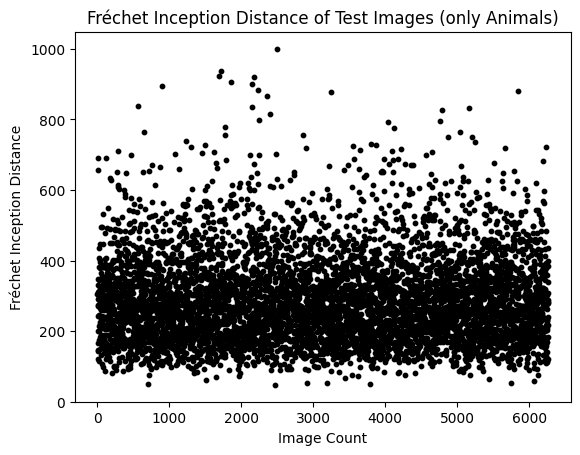

In [8]:
print("Maximum Fréchet Inception Distance: ","{:.4f}".format(max(FID_scores)))
print("Minimum Fréchet Inception Distance: ","{:.4f}".format(min(FID_scores)))
print("Average Fréchet Inception Distance: ","{:.4f}".format(sum(FID_scores)/len(FID_scores)))

indices_range = list(range(1, len(FID_scores) + 1))
plt.scatter(indices_range, FID_scores, color='black', marker='o', s=10)

plt.xlabel("Image Count")
plt.ylabel("Fréchet Inception Distance")
plt.title("Fréchet Inception Distance of Test Images (only Animals)")
plt.savefig("fid_plot_animal.png", dpi=512, bbox_inches='tight', pad_inches=0.1)
plt.show()

**Evaluate SSI (Structural Similarity Index)**

In [7]:
# Loop through the images and calculate SSI one by one
SSI_values = []
counter = 1
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)

    generated = image.crop((256,0,512,256))
    GT = image.crop((512,0,768,256))

    generated = np.array(generated)
    GT = np.array(GT)

    # Compute Structural Similarity Index (SSI) for each channel separately
    temp = []
    for i in range(3):  # Iterate over each channel
        ssi_index, _ = ssim(generated[:, :, i], GT[:, :, i], full=True)
        temp.append(ssi_index)

    # Average the SSIM indices for all channels
    average_ssi = np.mean(temp)

    SSI_values.append(average_ssi)

    counter += 1
    if (counter%100 == 0):
        print('.', end='')
    
print('Calculation Completed')

..............................................................Calculation Completed


Maximum Structural Similarity Index:  0.9322
Minimum Structural Similarity Index:  0.2259
Average Structural Similarity Index:  0.6898


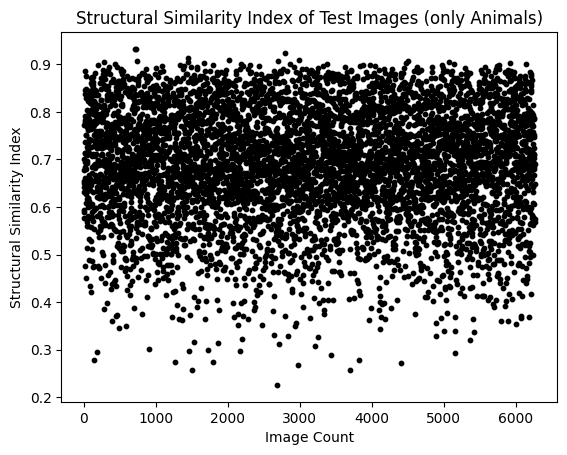

In [8]:
print("Maximum Structural Similarity Index: ","{:.4f}".format(max(SSI_values)))
print("Minimum Structural Similarity Index: ","{:.4f}".format(min(SSI_values)))
print("Average Structural Similarity Index: ","{:.4f}".format(sum(SSI_values) / len(SSI_values)))

indices_range = list(range(1, len(SSI_values) + 1))
plt.scatter(indices_range, SSI_values, color='black', marker='o', s=10)

plt.xlabel("Image Count")
plt.ylabel("Structural Similarity Index")
plt.title("Structural Similarity Index of Test Images (only Animals)")
plt.savefig("ssi_plot_animal.png", dpi=512, bbox_inches='tight', pad_inches=0.1)
plt.show()

**Calculate MSE (Mean Square Error)**

In [9]:
# Loop through the images and calculate MSE one by one
MSE_values = []
counter = 1

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)

    generated = np.array(image.crop((256,0,512,256)))
    GT = np.array(image.crop((512,0,768,256)))

    # Compute Mean Squared Error (MSE)
    mse = np.mean((generated - GT)**2)
    MSE_values.append(mse)
    
    counter += 1
    if (counter%100 == 0):
        print('.', end='')
    
print('Calculation Completed')

..............................................................Calculation Completed


Maximum Mean Square Error:  103.6319
Minimum Mean Square Error:  7.6255
Average Mean Square Error:  52.4653


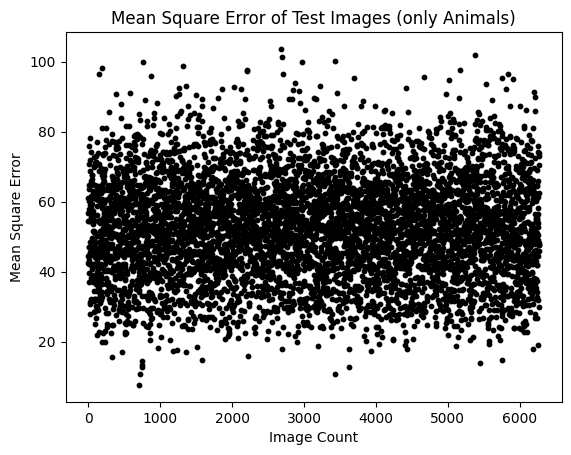

In [10]:
print("Maximum Mean Square Error: ","{:.4f}".format(max(MSE_values)))
print("Minimum Mean Square Error: ","{:.4f}".format(min(MSE_values)))
print("Average Mean Square Error: ","{:.4f}".format(sum(MSE_values) / len(MSE_values)))

indices_range = list(range(1, len(MSE_values) + 1))
plt.scatter(indices_range, MSE_values, color='black', marker='o', s=10)

plt.xlabel("Image Count")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error of Test Images (only Animals)")
plt.savefig("mse_plot_animal.png", dpi=512, bbox_inches='tight', pad_inches=0.1)
plt.show()